Loading Women's Data...

--- Total Demand for Family Planning (Married Women 15-49) ---
                   Total Demand
Location                       
Rwamagana                    73
Nyagatare                    82
Gatsibo                      77
Kayonza                      80
Kirehe                       81
Ngoma                        81
Bugesera                     76
East Province                79
Rwanda (National)            78
✅ Success! JSON: eastern_total_demand_planning.json, Plot: Total_Demand_Planning.png


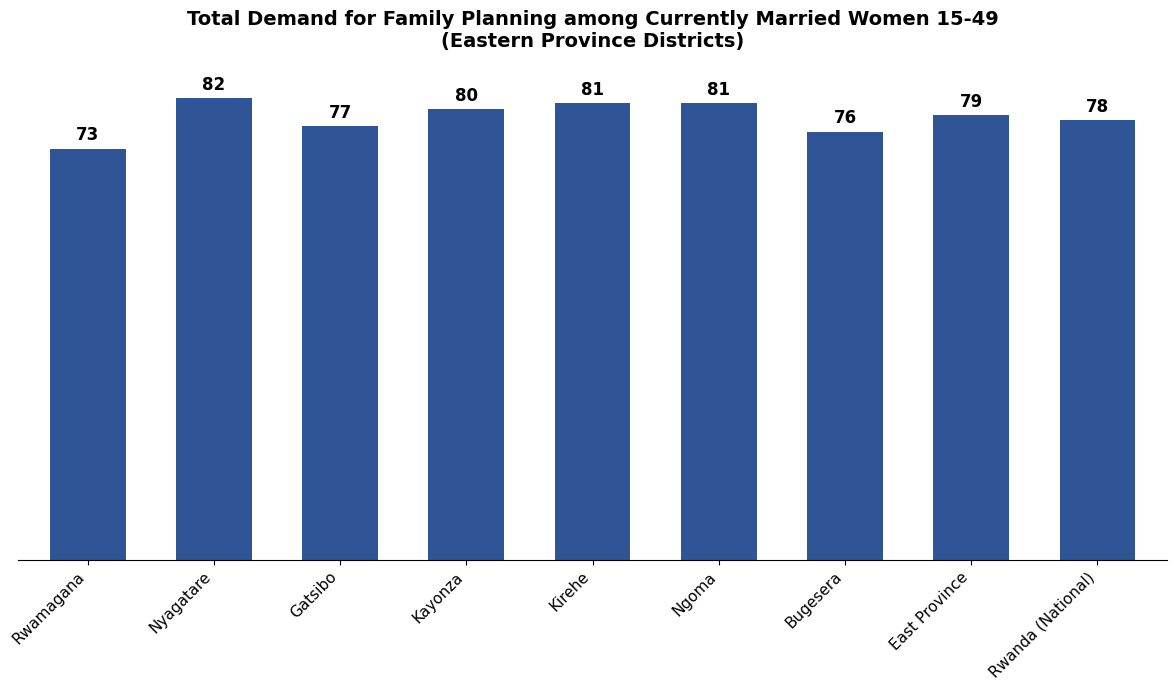

In [1]:
#!/usr/bin/env python3
# dhs_total_demand_planning.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# Eastern Province Districts
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Color for Total Demand
BAR_COLOR = "#2F5597" # Dark Blue

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 and up to next integer, below 0.5 down."""
    return int(math.floor(n + 0.5))

def get_total_demand_pct(df):
    """Calculates weighted Total Demand (v626a in 1, 2, 3, 4)."""
    if df.empty or df['w'].sum() == 0:
        return 0
    
    # Total Demand = Unmet Need (1,2) + Met Need (3,4)
    raw_pct = np.average(df['v626a'].isin([1, 2, 3, 4]), weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FILTERS ---
    # 1. Currently Married (v502 == 1) and Age 15-49
    df = df[(df['v502'] == 1) & (df['v012'] >= 15) & (df['v012'] <= 49)].copy()
    
    # 2. Weights & Numeric conversion for Unmet Need (v626a)
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    df['v626a'] = pd.to_numeric(df['v626a'], errors='coerce').fillna(0)

    # --- AGGREGATION ---
    results = {}
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'
    
    # A. Districts (Eastern Province = Region 5)
    df_east = df[df['v024'] == 5].copy()
    for d_code, d_name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == d_code]
        results[d_name] = get_total_demand_pct(subset)

    # B. Province Total
    results["East Province"] = get_total_demand_pct(df_east)

    # C. National Total
    results["Rwanda (National)"] = get_total_demand_pct(df)

    # Create DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Total Demand"])
    final_df.set_index("Location", inplace=True)
    
    print("\n--- Total Demand for Family Planning (Married Women 15-49) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_total_demand_planning.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Total Demand"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", figsize=(12, 7), color=BAR_COLOR, width=0.6, legend=False)

    plt.title("Total Demand for Family Planning among Currently Married Women 15-49\n(Eastern Province Districts)", 
              fontsize=14, fontweight="bold", pad=20)
    
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.xlabel("")
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    # Aesthetics
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    # Add Integer Labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontsize=12, fontweight="bold", color="black")

    plt.tight_layout()
    plt.savefig("Total_Demand_Planning.png", dpi=300)
    print(f"✅ Success! JSON: {json_name}, Plot: Total_Demand_Planning.png")